<a href="https://colab.research.google.com/github/cwmarris/pull-request-monitor/blob/master/OH_Introduction_to_NLP_03_SentimentExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Python Example

* Author: Amy Zhuang
* Last Updated: May 2021

## Sentiment Analysis Types


- Lexicon-based: The lexicon-based method has a dictionary of sentiment scores for each word in a sentence. The average sentiment score of each word in a sentence is used to calculate the sentiment of the whole sentence. There are two popular lexicon-based sentiment analysis python packages: TextBlob and VADER.
- Cloud API: Some cloud service providers have sentiment analysis as a service.  
- Machine Learning Model: Machine learning model method uses predictive model to predict the sentiment of a document. Based on whether the predictors are bag of words or sequence, either a binary classification model (e.g., logistic regression, SVM, Naive Bayesian, Random Forest etc.) or a RNN model can be used.


## Mount Google Drive


In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/My Drive/Colab Notebooks")

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


## Verify GPU and TPU

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import os
if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to TPU')
else:
  print("Connected to TPU")

Not connected to TPU


## Download Data

1. Go to: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
2. Click "Data Folder"
3. Download "sentiment labelled sentences.zip"
4. Unzip "sentiment labelled sentences.zip"
5. Copy the file "amazon_cells_labelled.txt" to Google drive

## Import Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 9.3MB/s 
     |████████████████████████████████| 1.1MB 51.7MB/s 
     |████████████████████████████████| 890kB 49.4MB/s 
     |████████████████████████████████| 2.9MB 52.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cc81b614ac9fb96673ba8f093024379c68060c07408b9ae4c337a38077a8e9cf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot as plt
import seaborn as sns
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn, optim
from torch.nn import functional as F
from collections import defaultdict


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

## Readin Data

In [ ]:
colnames = ['sentence','target']
amz_review = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=colnames)
amz_review.head()

,sentence,target
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


In [ ]:
amz_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   target    1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
amz_review['target'].value_counts()

1    500
0    500
Name: target, dtype: int64

## VADER

In [ ]:
!pip3 install -U nltk

     |████████████████████████████████| 1.5MB 2.9MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449905 sha256=dc5aff3c3eeab29e0d871367a4e1d85a2d6ac22206ffec8da23ec4f3bcf77c6f
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
amz_review['scores_VADER'] = amz_review['sentence'].apply(lambda s: sia.polarity_scores(s)['compound'])
amz_review['pred_VADER'] = amz_review['scores_VADER'].apply(lambda x: 1 if x >=0 else 0)
amz_review.head()

,sentence,target,scores_VADER,pred_VADER
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,-0.3535,0
1,"Good case, Excellent value.",1,0.8402,1
2,Great for the jawbone.,1,0.6249,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,-0.6145,0
4,The mic is great.,1,0.6249,1


In [ ]:
amz_review.tail()

,sentence,target,scores_VADER,pred_VADER
995,The screen does get smudged easily because it touches your ear and face.,0,0.3400,1
996,What a piece of junk.. I lose more calls on this phone.,0,-0.4019,0
997,Item Does Not Match Picture.,0,0.0000,1
998,The only thing that disappoint me is the infra red port (irda).,0,-0.4019,0
999,"You can not answer calls with the unit, never worked once!",0,0.0000,1


In [ ]:
# Compare Actual and Predicted
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(amz_review['target'],amz_review['pred_VADER'])

0.758

In [ ]:
print(classification_report(amz_review['target'],amz_review['pred_VADER']))

              precision    recall  f1-score   support

           0       0.95      0.54      0.69       500
           1       0.68      0.97      0.80       500

    accuracy                           0.76      1000
   macro avg       0.82      0.76      0.75      1000
weighted avg       0.82      0.76      0.75      1000



In [ ]:
cm = confusion_matrix(amz_review['target'],amz_review['pred_VADER'])
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no       272       228
true:yes       14       486


## Text Blob

In [ ]:
from textblob import TextBlob

amz_review['scores_TextBlob'] = amz_review['sentence'].apply(lambda s: TextBlob(s).sentiment.polarity)
amz_review['pred_TextBlob'] = amz_review['scores_TextBlob'].apply(lambda x: 1 if x >=0 else 0)
amz_review.head()

,sentence,target,scores_VADER,pred_VADER,score_TextBlob,pred_TextBlob,scores_TextBlob
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,-0.3535,0,0.000000,1,0.000000
1,"Good case, Excellent value.",1,0.8402,1,0.850000,1,0.850000
2,Great for the jawbone.,1,0.6249,1,0.800000,1,0.800000
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,-0.6145,0,0.390625,1,0.390625
4,The mic is great.,1,0.6249,1,0.800000,1,0.800000


In [ ]:
amz_review.tail()

,sentence,target,scores_VADER,pred_VADER,score_TextBlob,pred_TextBlob,scores_TextBlob
995,The screen does get smudged easily because it touches your ear and face.,0,0.3400,1,0.433333,1,0.433333
996,What a piece of junk.. I lose more calls on this phone.,0,-0.4019,0,0.500000,1,0.500000
997,Item Does Not Match Picture.,0,0.0000,1,0.000000,1,0.000000
998,The only thing that disappoint me is the infra red port (irda).,0,-0.4019,0,0.000000,1,0.000000
999,"You can not answer calls with the unit, never worked once!",0,0.0000,1,0.000000,1,0.000000


In [ ]:
# Compare Actual and Predicted
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(amz_review['target'],amz_review['pred_TextBlob'])

0.688

In [ ]:
print(classification_report(amz_review['target'],amz_review['pred_TextBlob']))

              precision    recall  f1-score   support

           0       0.93      0.41      0.57       500
           1       0.62      0.97      0.76       500

    accuracy                           0.69      1000
   macro avg       0.77      0.69      0.66      1000
weighted avg       0.77      0.69      0.66      1000



In [ ]:
cm = confusion_matrix(amz_review['target'],amz_review['pred_TextBlob'])
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no       204       296
true:yes       16       484


## Comparision in Distribution

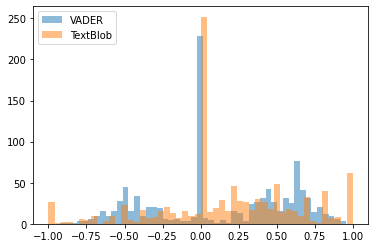

In [ ]:
plt.hist(amz_review['scores_VADER'], bins=50, alpha=0.5, label='VADER')
plt.hist(amz_review['scores_TextBlob'], bins=50, alpha=0.5, label='TextBlob')
plt.legend(loc='upper left')
plt.show()

## Data Preprocessing for Models

In [ ]:
X, y = (amz_review['sentence'].values, amz_review['target'].values) 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# check the max length of the sentences.
amz_review.sentence.str.len().max()

149

In [ ]:
len(X)

1000

In [ ]:
len(X[1])

27

In [ ]:
check_len = []
for i in range(len(X)):
  sentence_len=len(X[i])
  check_len.append(sentence_len)


Text(3.674999999999997, 0.5, 'Frequency')

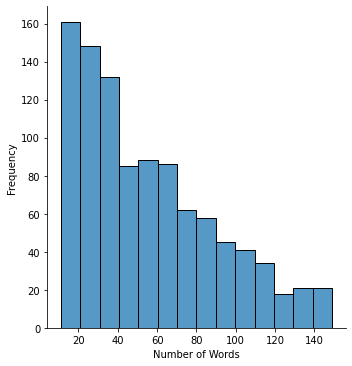

In [ ]:
sns.displot(check_len)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

From the above graph, the x-axis is the number of words and the y-axis is the number of reviews. We can see that if we choose the maxlen=20, we can get infromation from around 840 (1000-160) number of reviews.

In [ ]:
tk = Tokenizer(lower = True)
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=20, padding='post')

In [ ]:
type(X_pad)

numpy.ndarray

In [ ]:
X_pad[0]

array([117,   5,  53, 214,  11,  47,   8, 155,   4,  19, 337,  19,   1,
       546, 416,   2, 241, 190,   6, 812], dtype=int32)

In [ ]:
X[0]

'So there is no way for me to plug it in here in the US unless I go by a converter.'

## Train Test Split for LSTM and GRU Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.20, random_state = 0)

## Build RNN LSTM Model

The embedding layer represent each word using a vector. ```input_dim```is the size of the volcabulary. ```output_dim``` is the dimension of the embedding vector. ```input_length```is the length of the padded sequence.
The LSTM layer contains multiple parallel LSTM units, structurally identical but each eventually "learning to remember" some different thing.


In [ ]:
import tensorflow as tf; print(tf.__version__)

2.3.0


### Model Building

In [ ]:
checkpoint_path='/content/drive/My Drive/Colab Notebooks/testLSTMmodel.h5'

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tk.word_counts.keys())+1, output_dim=128,input_length = 20))
model.add(LSTM(units=200, dropout=0.2, recurrent_dropout=0.2)) # dropout is for the vertical inputs of x values, and recurrent_dropout is for the dropout of horizontal recurrent input.
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='auto')
]
model.fit(X_train, y_train, batch_size=50, epochs = 50, validation_split=0.2, callbacks=keras_callbacks)

Epoch 1/50
13/13 [==============================] - 3s 197ms/step - loss: 0.6970 - accuracy: 0.4781 - val_loss: 0.6985 - val_accuracy: 0.4563
Epoch 2/50
13/13 [==============================] - 2s 131ms/step - loss: 0.6915 - accuracy: 0.5609 - val_loss: 0.6925 - val_accuracy: 0.5063
Epoch 3/50
13/13 [==============================] - 2s 127ms/step - loss: 0.6229 - accuracy: 0.6687 - val_loss: 0.5941 - val_accuracy: 0.6687
Epoch 4/50
13/13 [==============================] - 2s 128ms/step - loss: 0.3076 - accuracy: 0.8813 - val_loss: 0.4621 - val_accuracy: 0.7688
Epoch 5/50
13/13 [==============================] - 2s 124ms/step - loss: 0.1420 - accuracy: 0.9484 - val_loss: 0.8594 - val_accuracy: 0.7437
Epoch 6/50
13/13 [==============================] - 2s 129ms/step - loss: 0.0590 - accuracy: 0.9797 - val_loss: 0.5941 - val_accuracy: 0.7875
Epoch 7/50
13/13 [==============================] - 2s 124ms/step - loss: 0.0221 - accuracy: 0.9969 - val_loss: 0.9273 - val_accuracy: 0.7875
Epoch 

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 128)           240512    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 503,913
Trainable params: 503,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(tk.word_counts.keys())+1

1879

In [ ]:
# 1st layer number of parameters: number of input_dim*output_dim
1879*128

240512

In [ ]:
# 2nd LSTM layer number of parameters: 4*(output_dim_of_last_layer*units+units**2+units) 
4*(128*200+200*200+200)

263200

In [ ]:
# 3rd output layer number of parameters: output_dim_of_last_layer*output_dim_of_this_layer+output_dim_of_this_layer
200*1+1

201

### Model Evaluation

In [ ]:
# Load the best model
model = load_model(checkpoint_path)

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.00%


## Build RNN GRU (Gated Recurrent Unit) Model

The key difference between a GRU and an LSTM is that a GRU has two gates (reset and update gates) whereas an LSTM has three gates (namely input, output and forget gates)

In [ ]:
checkpoint_path='/content/drive/My Drive/Colab Notebooks/testGRUmodel.h5'

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(tk.word_counts.keys())+1, output_dim=128,input_length = 20))
model_gru.add(GRU(200))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='auto')
]
model_gru.fit(X_train, y_train, batch_size=50, epochs = 50,validation_split=0.2, callbacks=keras_callbacks)

Epoch 1/50
13/13 [==============================] - 1s 94ms/step - loss: 0.6959 - accuracy: 0.4938 - val_loss: 0.6947 - val_accuracy: 0.4625
Epoch 2/50
13/13 [==============================] - 1s 66ms/step - loss: 0.6909 - accuracy: 0.5453 - val_loss: 0.6935 - val_accuracy: 0.5063
Epoch 3/50
13/13 [==============================] - 1s 66ms/step - loss: 0.6854 - accuracy: 0.5984 - val_loss: 0.6902 - val_accuracy: 0.5125
Epoch 4/50
13/13 [==============================] - 1s 66ms/step - loss: 0.6426 - accuracy: 0.6469 - val_loss: 0.6196 - val_accuracy: 0.6375
Epoch 5/50
13/13 [==============================] - 1s 64ms/step - loss: 0.4878 - accuracy: 0.8391 - val_loss: 0.5885 - val_accuracy: 0.7312
Epoch 6/50
13/13 [==============================] - 1s 65ms/step - loss: 0.2120 - accuracy: 0.9359 - val_loss: 0.4706 - val_accuracy: 0.7875
Epoch 7/50
13/13 [==============================] - 1s 65ms/step - loss: 0.0751 - accuracy: 0.9828 - val_loss: 1.0210 - val_accuracy: 0.7875
Epoch 8/50
13

### Model Evaluation

In [ ]:
# Load the best model
model = load_model(checkpoint_path)

In [ ]:
scores = model_gru.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.00%


## BERT

Reference: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

### BERT Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Special Token

In [ ]:
# Special Tokens: [SEP] - marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# Special Tokens: [CLS] - we must add this token to the start of each sentence, so BERT knows we’re doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
# Special Tokens: padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# Special Tokens: unkown
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

#### Example

In [ ]:
sample_text='DSP is a course for data science and machine learning.'

In [ ]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
print(f'Sentence: {sample_text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: DSP is a course for data science and machine learning.
Tokens: ['DS', '##P', 'is', 'a', 'course', 'for', 'data', 'science', 'and', 'machine', 'learning', '.']
Token IDs: [18448, 2101, 1110, 170, 1736, 1111, 2233, 2598, 1105, 3395, 3776, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 18448,  2101,  1110,   170,  1736,  1111,  2233,  2598,  1105,
         3395,  3776,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'DS',
 '##P',
 'is',
 'a',
 'course',
 'for',
 'data',
 'science',
 'and',
 'machine',
 'learning',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

#### Choosing Sequence Length

In [ ]:
token_lens = []
for txt in amz_review.sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

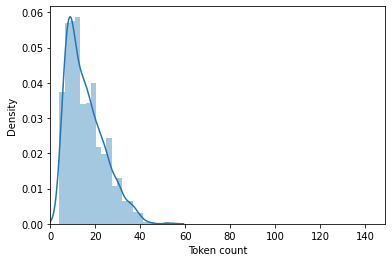

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, amz_review.sentence.str.len().max()]);
plt.xlabel('Token count')

### Train Test Split

In [ ]:
df_train, df_test = train_test_split(
  amz_review,
  test_size=0.2,
  stratify=amz_review['target'],
  random_state=0
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  stratify=df_test['target'],
  random_state=0
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((800, 2), (100, 2), (100, 2))

### Load Data

In [ ]:
MAX_LEN=20

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True, #depreciated
      # padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df['sentence'].to_numpy(),
    targets=df['target'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 20])
torch.Size([16, 20])
torch.Size([16])


### Build Model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
# The last_hidden_state is a sequence of hidden states of the last layer of the model.
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

32 is the max_length for the example text. There is one hidden state for each of the 32 tokens. 768 is the number of hidden units in base BERT.

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape # Embedding output. We can think of it as a summary of the content.

torch.Size([1, 768])

In [ ]:
pooled_output

tensor([[-0.6969,  0.4655,  0.9997, -0.9845,  0.9469,  0.8062,  0.9525, -0.9912,
         -0.9315, -0.6231,  0.9614,  0.9953, -0.9980, -0.9996,  0.7337, -0.9349,
          0.9794, -0.6189, -0.9999, -0.6448, -0.3649, -0.9996,  0.1486,  0.9472,
          0.9441,  0.0524,  0.9681,  0.9999,  0.8278, -0.3314,  0.1614, -0.9769,
          0.8667, -0.9980,  0.1179,  0.2168,  0.7371, -0.2879,  0.8317, -0.9285,
         -0.6839, -0.7559,  0.5917, -0.5311,  0.8996,  0.2129,  0.2172, -0.1329,
         -0.1384,  0.9998, -0.9070,  0.9941, -0.9935,  0.9882,  0.9785,  0.4273,
          0.9866,  0.1613, -0.9988,  0.3731,  0.9487,  0.1924,  0.8418, -0.1986,
          0.0750, -0.4077, -0.7958,  0.1057, -0.4370,  0.2784,  0.2699,  0.3081,
          0.9592, -0.8326,  0.0282, -0.8911,  0.1940, -0.9996,  0.9486,  0.9999,
          0.6675, -0.9991,  0.9847, -0.3002, -0.5742,  0.5608, -0.9989, -0.9987,
          0.0415, -0.6804,  0.8382, -0.9746,  0.4034, -0.8318,  0.9999, -0.9368,
         -0.1425,  0.3102,  

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = [0,1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)

In [ ]:
input_ids # first batch of the train data loader

tensor([[  101,  1398,  1107,  1155,   117,   146,   112,   182,  2385,  8723,
          1114,  1142,  4779,   119,   102,     0,     0,     0,     0,     0],
        [  101,   146,  1138,  1106,  1329,  1103, 10471,  3811,  9641,  1116,
          2136,   117,  1133,  1122, 12543,  1113,  2785,  1218,   119,   102],
        [  101,  1188,  3317,  1110,  7891,  1111,  1234,  1176,  1143,  2133,
          4942,  1132,  1304,  7246,   119,   102,     0,     0,     0,     0],
        [  101,  5853,  1112,  1758,   119,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   146,  1108,  1682,  1106,  1202,  1490, 17693,  1158,  1107,
          1103,  1610,  1114,  1185,  2463,   119,   102,     0,     0,     0],
        [  101,  1422, 11864,   111,   146,  1208,  1243,  1632,  7602,   119,
           138,  1376,  5865,   117,  1133,  2099,  1110,  1632,   119,   102],
        [  101,  2098,   170,  1703,  7305,   

In [ ]:
attention_mask = data['attention_mask'].to(device)

In [ ]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

In [ ]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 20])
torch.Size([16, 20])


In [ ]:
from torch.nn import functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7172, 0.2828],
        [0.7152, 0.2848],
        [0.7219, 0.2781],
        [0.5825, 0.4175],
        [0.6124, 0.3876],
        [0.6941, 0.3059],
        [0.6391, 0.3609],
        [0.7603, 0.2397],
        [0.6431, 0.3569],
        [0.6887, 0.3113],
        [0.6396, 0.3604],
        [0.7245, 0.2755],
        [0.5858, 0.4142],
        [0.7517, 0.2483],
        [0.6700, 0.3300],
        [0.7359, 0.2641]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

The scheduler gets called every time a batch is fed to the model. We’re avoiding exploding gradients by clipping the gradients of the model using clipgrad_norm.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.48665341928601263 accuracy 0.77875


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.40361499999250683 accuracy 0.86

Epoch 2/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3057754861935973 accuracy 0.89375


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5838208831846714 accuracy 0.84

Epoch 3/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.23230868175625802 accuracy 0.93375


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4291017422718661 accuracy 0.88

Epoch 4/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.1372149334475398 accuracy 0.96125


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5677490872996194 accuracy 0.9

Epoch 5/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.09560541208833456 accuracy 0.9775


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.550334817197706 accuracy 0.91

Epoch 6/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.05945142090320587 accuracy 0.9862500000000001


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5562760450744203 accuracy 0.9

Epoch 7/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.03840944638475776 accuracy 0.98875


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5318383054940828 accuracy 0.92

Epoch 8/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.014008238068781794 accuracy 0.99375


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5971973272971809 accuracy 0.91

Epoch 9/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.008814937287243084 accuracy 0.995


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6093123152220089 accuracy 0.92

Epoch 10/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0073237852938473225 accuracy 0.99625


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6121098469344101 accuracy 0.93

CPU times: user 44.7 s, sys: 17.1 s, total: 1min 1s
Wall time: 1min 20s


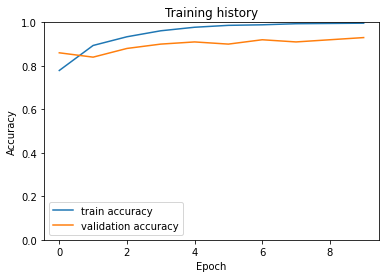

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
test_acc.item()

0.88

### Prediction

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
y_review_texts

['Price is good too.',
 'Small, sleek, impressive looking, practical setup with ample storage in place.',
 "I'm returning them.",
 'Jawbone Era is awesome too!',
 'As an earlier review noted, plug in this charger and nothing happens.',
 'How can that be?The audio quality is poor.',
 'Att is not clear, sound is very distorted and you have to yell when you talk.',
 'I had ordered a motorola data cable, got a very well finished and working product.',
 'The bottowm line...another worthless, cheap gimmick from Sprint.',
 'Everything worked on the first try.The device was certainly engineered in a clever way and the construction feels good.',
 'The internet access was fine, it the rare instance that it worked.',
 "I've had this bluetoooth headset for some time now and still not comfortable with the way it fits on the ear.",
 'Great phone!.',
 'Beautiful styling though.',
 'Battery life is also great!',
 'Really good product.',
 "No ear loop needed, it's tiny and the sound is great.",
 'An Aw

In [ ]:
y_pred

tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1])

In [ ]:
y_pred_probs

tensor([[-3.4317,  4.2389],
        [-3.4933,  4.1034],
        [-0.6074,  1.3725],
        [-2.6274,  4.0833],
        [ 3.4333, -4.2102],
        [ 3.6744, -4.5175],
        [ 3.5783, -4.4066],
        [-3.1909,  4.3594],
        [ 3.6598, -4.4653],
        [-3.4637,  4.2456],
        [-3.3205,  4.3288],
        [ 2.8478, -3.2403],
        [-3.4992,  4.0351],
        [-3.4609,  4.1983],
        [-3.3334,  4.3588],
        [-3.5069,  4.1292],
        [-3.0566,  4.3684],
        [ 2.2552, -3.1006],
        [-3.4409,  4.2362],
        [-3.4370,  4.0501],
        [-3.3564,  4.3334],
        [-3.5769,  3.9179],
        [ 3.6613, -4.4544],
        [-1.6006,  2.9504],
        [ 1.9262, -2.6830],
        [ 3.6980, -4.4580],
        [ 3.5654, -4.3720],
        [ 3.7235, -4.5513],
        [ 3.5852, -4.4214],
        [-2.9117,  4.0679],
        [-2.7459,  4.2377],
        [ 1.0481, -1.3960],
        [ 2.5555, -3.6527],
        [ 3.0256, -3.8936],
        [ 3.5741, -4.3791],
        [ 3.6051, -4

In [ ]:
y_test

tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1])

### Performance

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        50
           1       0.87      0.90      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



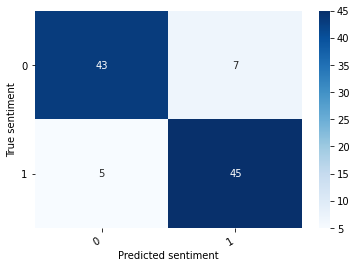

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Check One Example

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
from textwrap import wrap
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I'm returning them.

True sentiment: 0


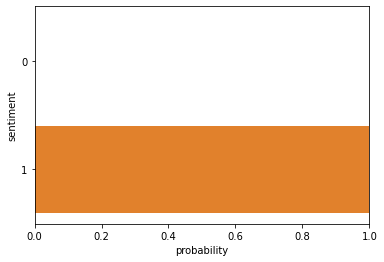

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Preding Raw Text

In [ ]:
review_text = "DSP is a great course!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [ ]:
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

In [ ]:
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: DSP is a great course!
Sentiment  : 1
